# Tutorial with Qiskit
This notebook demonstrates several examples of generating Quantum Convolutional Neural Networks (QCNNs) using the package. Default circuits/ansatzes for convolution and pooling operations are shown, such as the CRZ gate for convolutions and CNOT for pooling, to facilitate an easy visual representation of the package's functionality. The section [custom unitaries](#sec_customunitary) illustrates how to specify custom unitaries for convolutions, pooling, or other primitives.

**Important**
Qiskit requires QASM valid qubit names, such as "q1", "q2" and won't accept pure ints to reference qubits. For this reason when specifying qubits with `Qfree()`, if you provide ints, they will be prepended with a "q". i.e.
`Qfree(3) -> ["q1", "q2", "q3"]`

`Qfree([5,6,9]) -> ["q5", "q6", "q9"]`

`Qfree(["qubit_1","qubit_2","qubit_3"]) -> ["qubit_1","qubit_2","qubit_3"]`

___
*A cute robot building itself with artifical intelligence, pencil drawing -  generated with* [Dall$\cdot$E 2](https://openai.com/dall-e-2/)

<img src="../img/DALL·E 2022-08-17 11.48.32 - A cute robot building itself with artifical intelligence, pencil drawing.png" alt="drawing" width="200"/>

In [1]:
# Load libraries
import numpy as np

In [2]:
# Core library functionality
from dynamic_qcnn import Qcnn, Qfree, Qconv, Qpool, Qdense, plot_motif, plot_motifs

In [3]:
# Specific to Qiskit
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
from dynamic_qcnn.qiskit import convert_graph_to_circuit_qiskit

### Basic example
We create one of the architectures discussed in [Lourens et al.](https://arxiv.org/pdf/2210.15073.pdf). This architecture is semantically described as repeating a convolution of stride 1 and pooling from bottom to top on 8 qubits until one remain.

<img src="../img/hierarchical_motifs.drawio.svg" alt="hierarchical motifs" width="900"/>

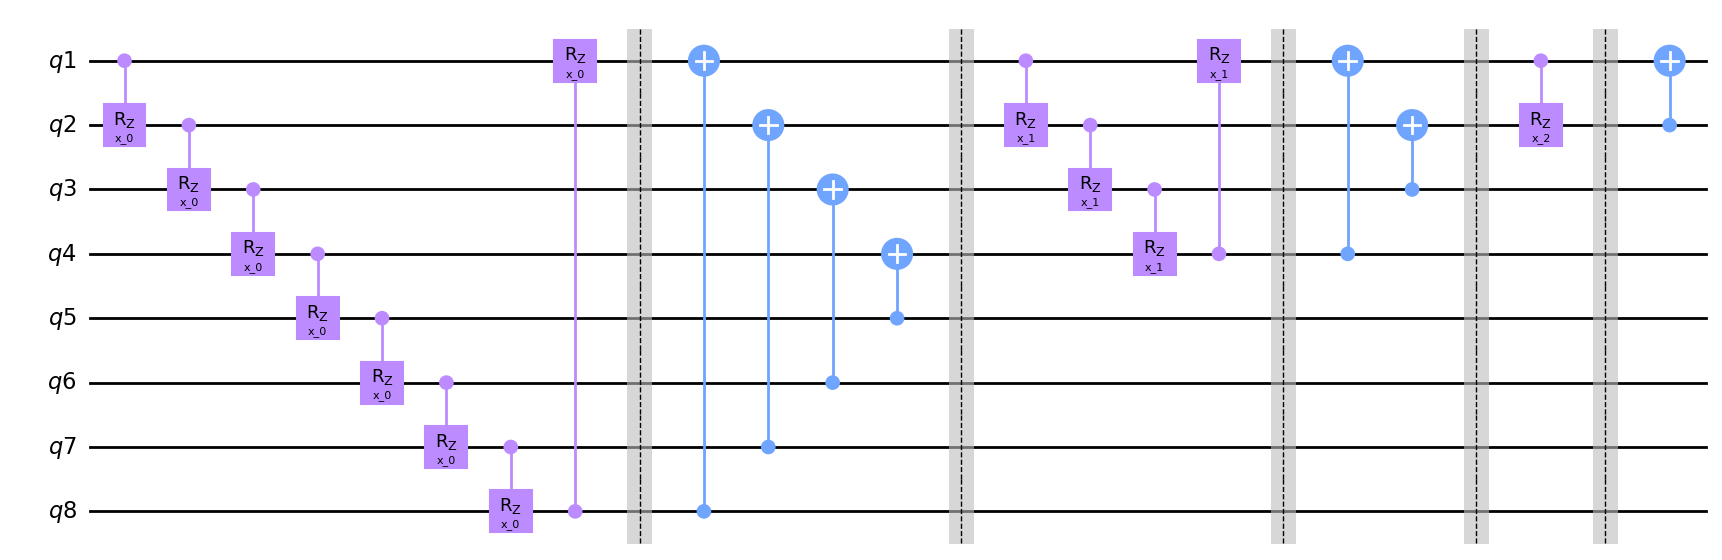

In [4]:
m = Qfree(8) + (Qconv(1) + Qpool(filter="right")) * 3

circuit, symbols = convert_graph_to_circuit_qiskit(m)
circuit.draw("mpl")

### Building blocks
Circuit architectures are created by stacking motifs hierarchacially, the lowest level motifs (primitives) are building blocks for higher level ones. On a high level you can regard a primitive as a layer such as convolution or pooling and we're creating a sequence of layers for the circuit. This view only captures hierarchical architectures of two levels (*level 1 -> primitives, level 2 -> sequence of primitves*). The framework is more general in that there is no limit to the number of levels used to represent an architecture. See the comparison below:

**Layer view**
 - qcnn = (Convolution, Pooling, Convolution, Pooling, Convolution, Convolution, Convolution, Pooling, Convolution, Pooling)

**Hierarchical view**
 - m2_1 = (Convolution, Pooling)
 - m2_2 = (Convolution, Convolution)
 - m3_1 = (m2_1, m2_1)
 - qcnn = (m3_1, m2_2, m3_1)

#### Free qubit primitive
We first need to specify the qubits for operations to act, this is achieved with the `Qfree` primitive. It is a special motif with no operational effect that makes qubits available and unavailable for succesive operations. 

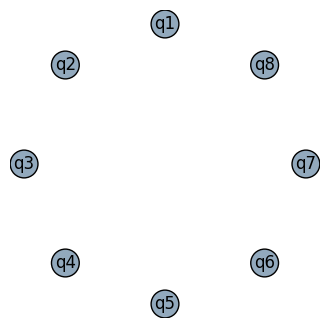

In [5]:
# Free primitive, can also recieve a list of qubit lables to make available.
q8 = [f"q{i}" for i in range(1,9,1)]
free = Qfree(q8)  # Qfree(8) or Qfree([2,6,4,10]) or Qfree(["q1", "q2"])

fig, ax = plot_motif(free)

#### Convolution primitive
To visualise the convolution operation we free up 8 qubits and add a convolution of stride 5 motif

Type of object	 <class 'dynamic_qcnn.core.Qcnn'>
First motif	 <class 'dynamic_qcnn.core.Qfree'>
Second motif	 <class 'dynamic_qcnn.core.Qconv'>



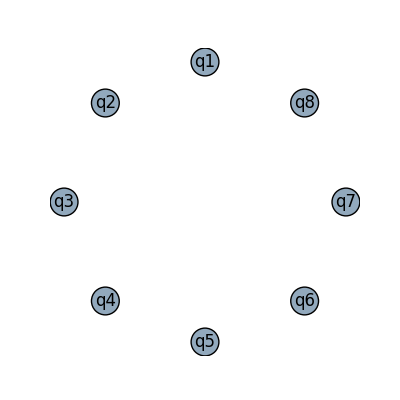
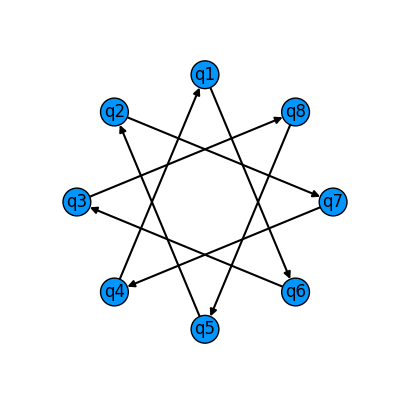

[<Figure size 400x400 with 1 Axes>, <Figure size 400x400 with 1 Axes>]

In [6]:
# Convolution of stride 3, try out other stride values
convolution = Qconv(stride=5)
conv_on_8_qubits = Qfree(q8) + convolution

# Note the type of 'conv_on_8_qubits', it's a qcnn with two motifs: (Qfree, Qconv)
print(f"Type of object\t {type(conv_on_8_qubits)}")
print(f"First motif\t {type(conv_on_8_qubits.tail)}")
print(f"Second motif\t {type(conv_on_8_qubits.tail.next)}")
plot_motifs(conv_on_8_qubits, all_motifs=True)

**Qiskit Circuit representation**

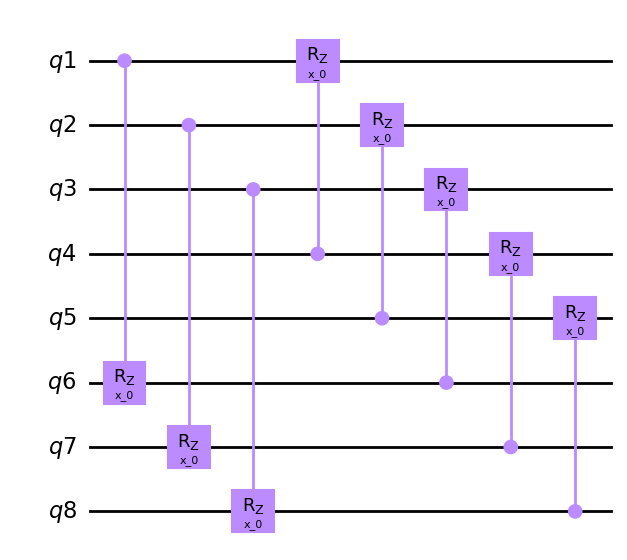

In [7]:
circuit, symbols = convert_graph_to_circuit_qiskit(conv_on_8_qubits)
circuit.draw("mpl")

#### Pooling primitive


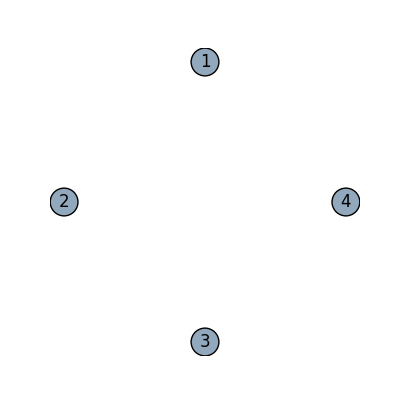
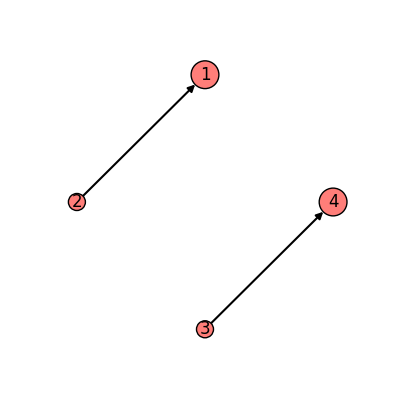

In [8]:
# Pooling from inside out, other values for filter: right, left, inside, outside, even, odd or a bitstring like 0100
pooling = Qpool(filter="inside")
pool_on_4_qubits = Qfree(4) + pooling

figs = plot_motifs(pool_on_4_qubits, all_motifs=True)

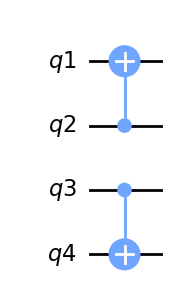

In [9]:
circuit, symbols = convert_graph_to_circuit_qiskit(pool_on_4_qubits)
circuit.draw("mpl")

#### Dense primitive


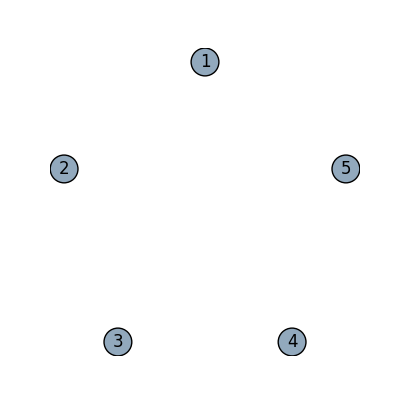
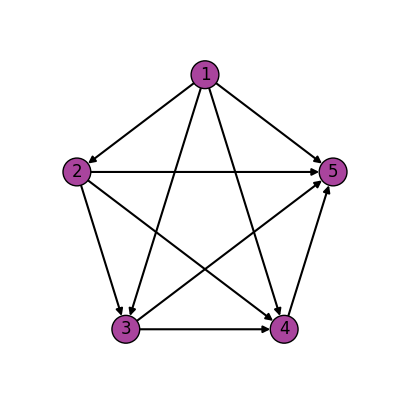

In [10]:
# Dense primitive, does all pairwise combinations between available qubits, for all permutations set permutations=True
dense = Qdense(permutations=False)
dense_on_5_qubits = Qfree(5) + dense

figs = plot_motifs(dense_on_5_qubits, all_motifs=True)

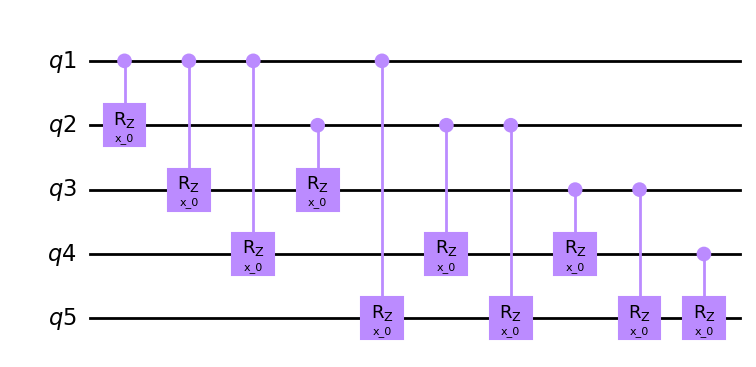

In [11]:
circuit, symbols = convert_graph_to_circuit_qiskit(dense_on_5_qubits)
circuit.draw("mpl")

## Reverse binary tree


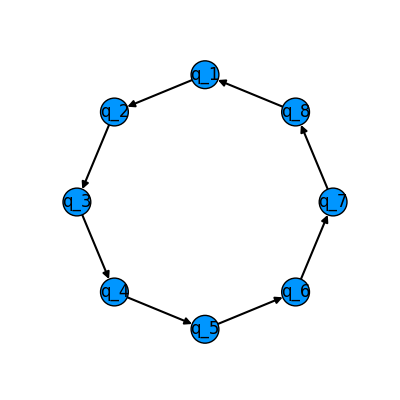
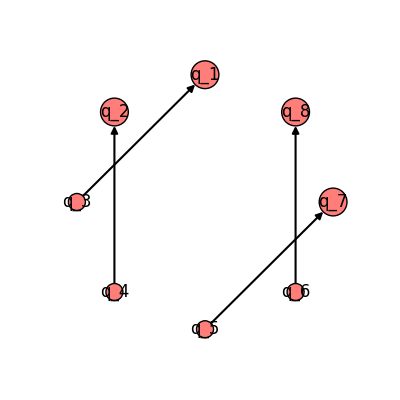
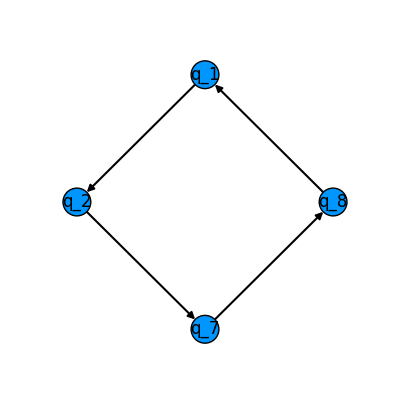
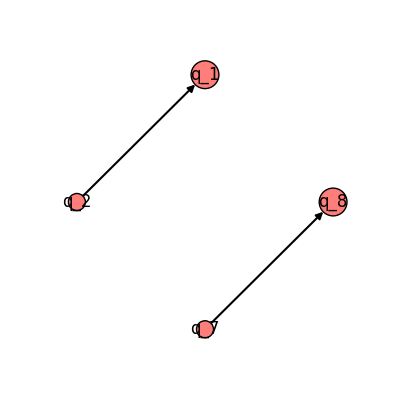
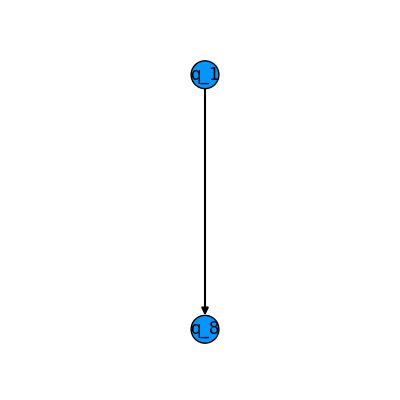
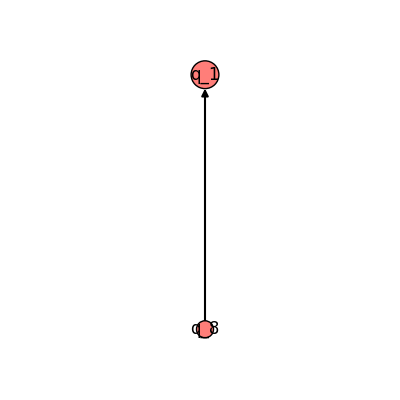

In [13]:
### Reverse binary tree

# Change these values
# ---------
N = [f"q_{i}" for i in range(1,9,1)]  # any power of two
s_c = 1  # 1,2,3, ...
f = "inside"  # right, left, inside, outside, even, odd
s_p = 0  # 1,2,3, ...
# ---------

# level 1
m1_1 = Qconv(stride=s_c)
m1_2 = Qpool(stride=s_p, filter=f)
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(len(N)))

figs = plot_motifs(m3_1)

**Corresponding circuit**

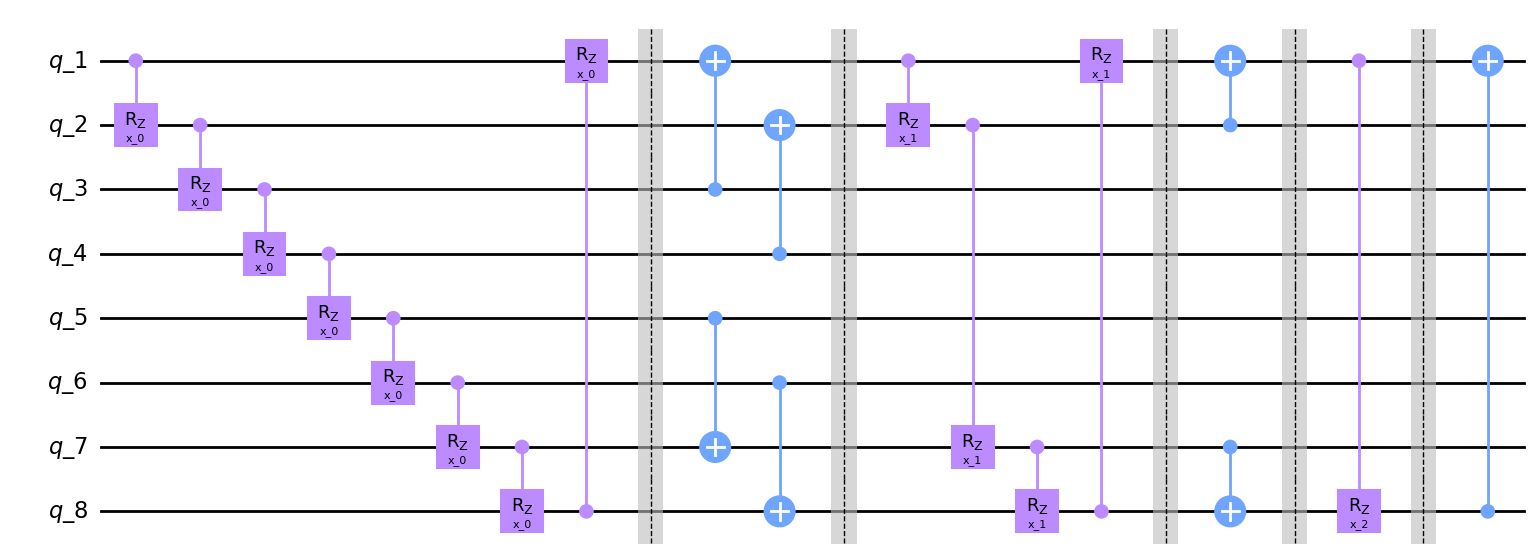

In [14]:
circuit, symbols = convert_graph_to_circuit_qiskit(m3_1)
circuit.draw("mpl")

### More arbitrary examples to show what is possible

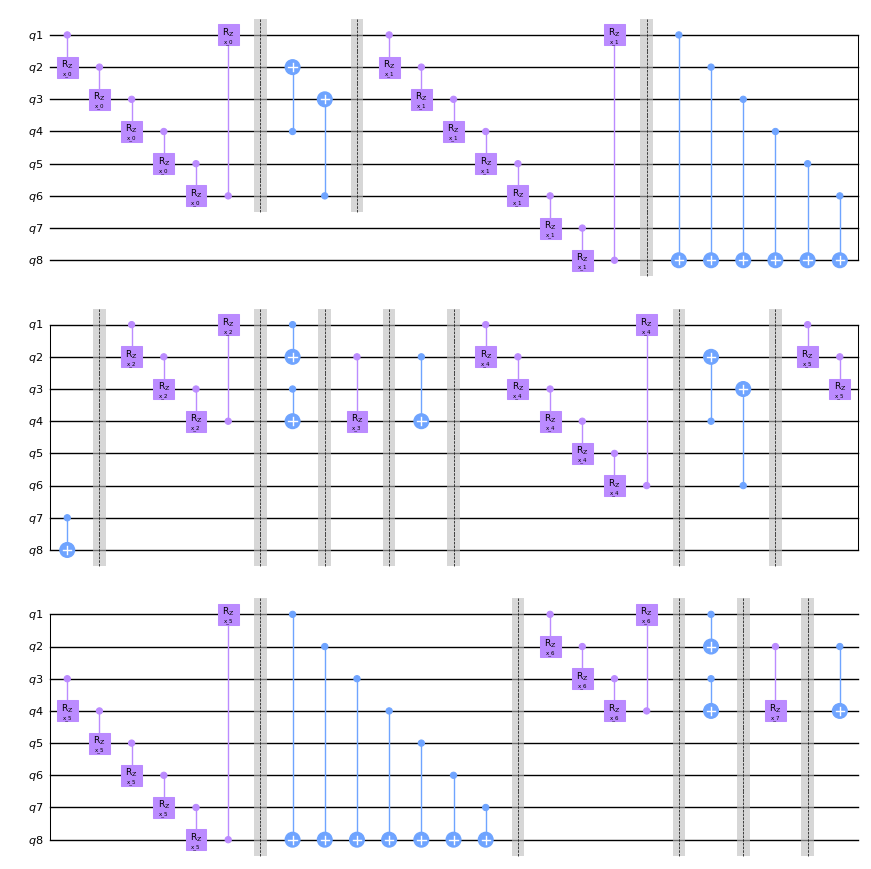

In [15]:
m1 = Qfree(6) + Qconv()
m2 = m1 + Qpool(1, "000101")
m3 = m2 + Qfree(8) + Qconv(1) + Qpool(2, "11111110")
m4 = m3 + Qfree(4) + (Qconv(1) + Qpool(0, "even")) * 2
m5 = m4 + m4
circuit, symbols = convert_graph_to_circuit_qiskit(m5)
circuit.draw("mpl", scale=0.5)


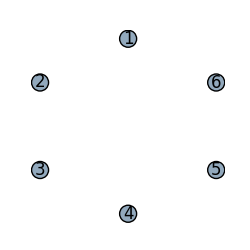
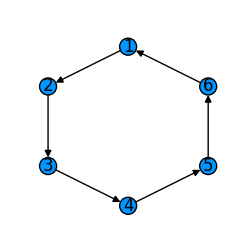
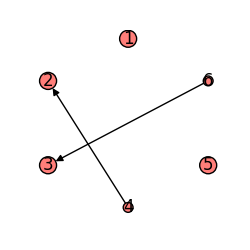
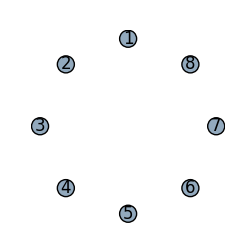
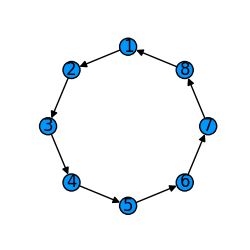
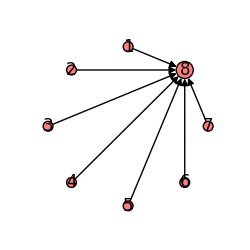
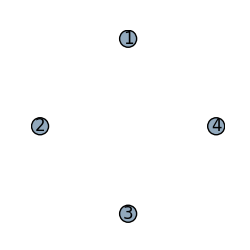
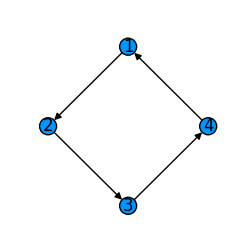
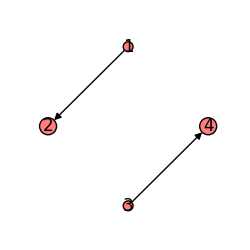
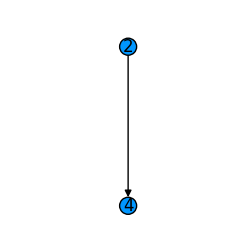
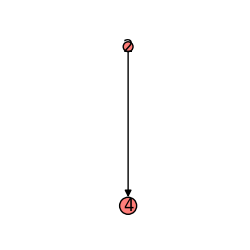
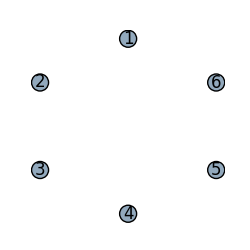
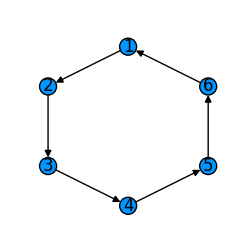
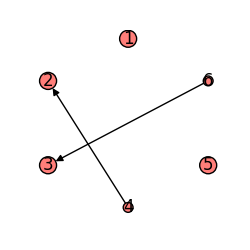
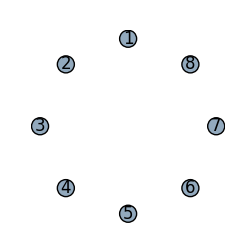
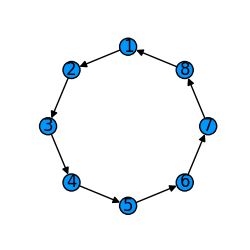
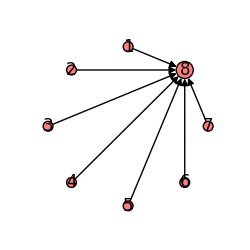
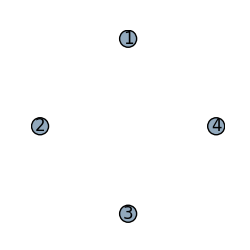
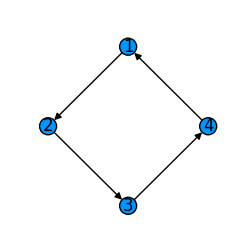
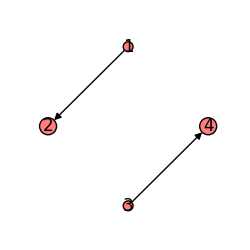
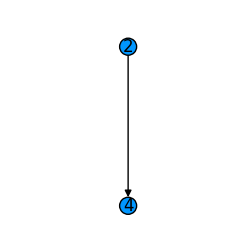
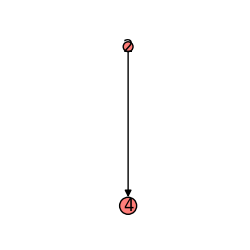

In [17]:
figs = plot_motifs(
    m5, all_motifs=True, figsize=(2.5, 2.5), node_large=150, node_small=50, edge_width=1
)

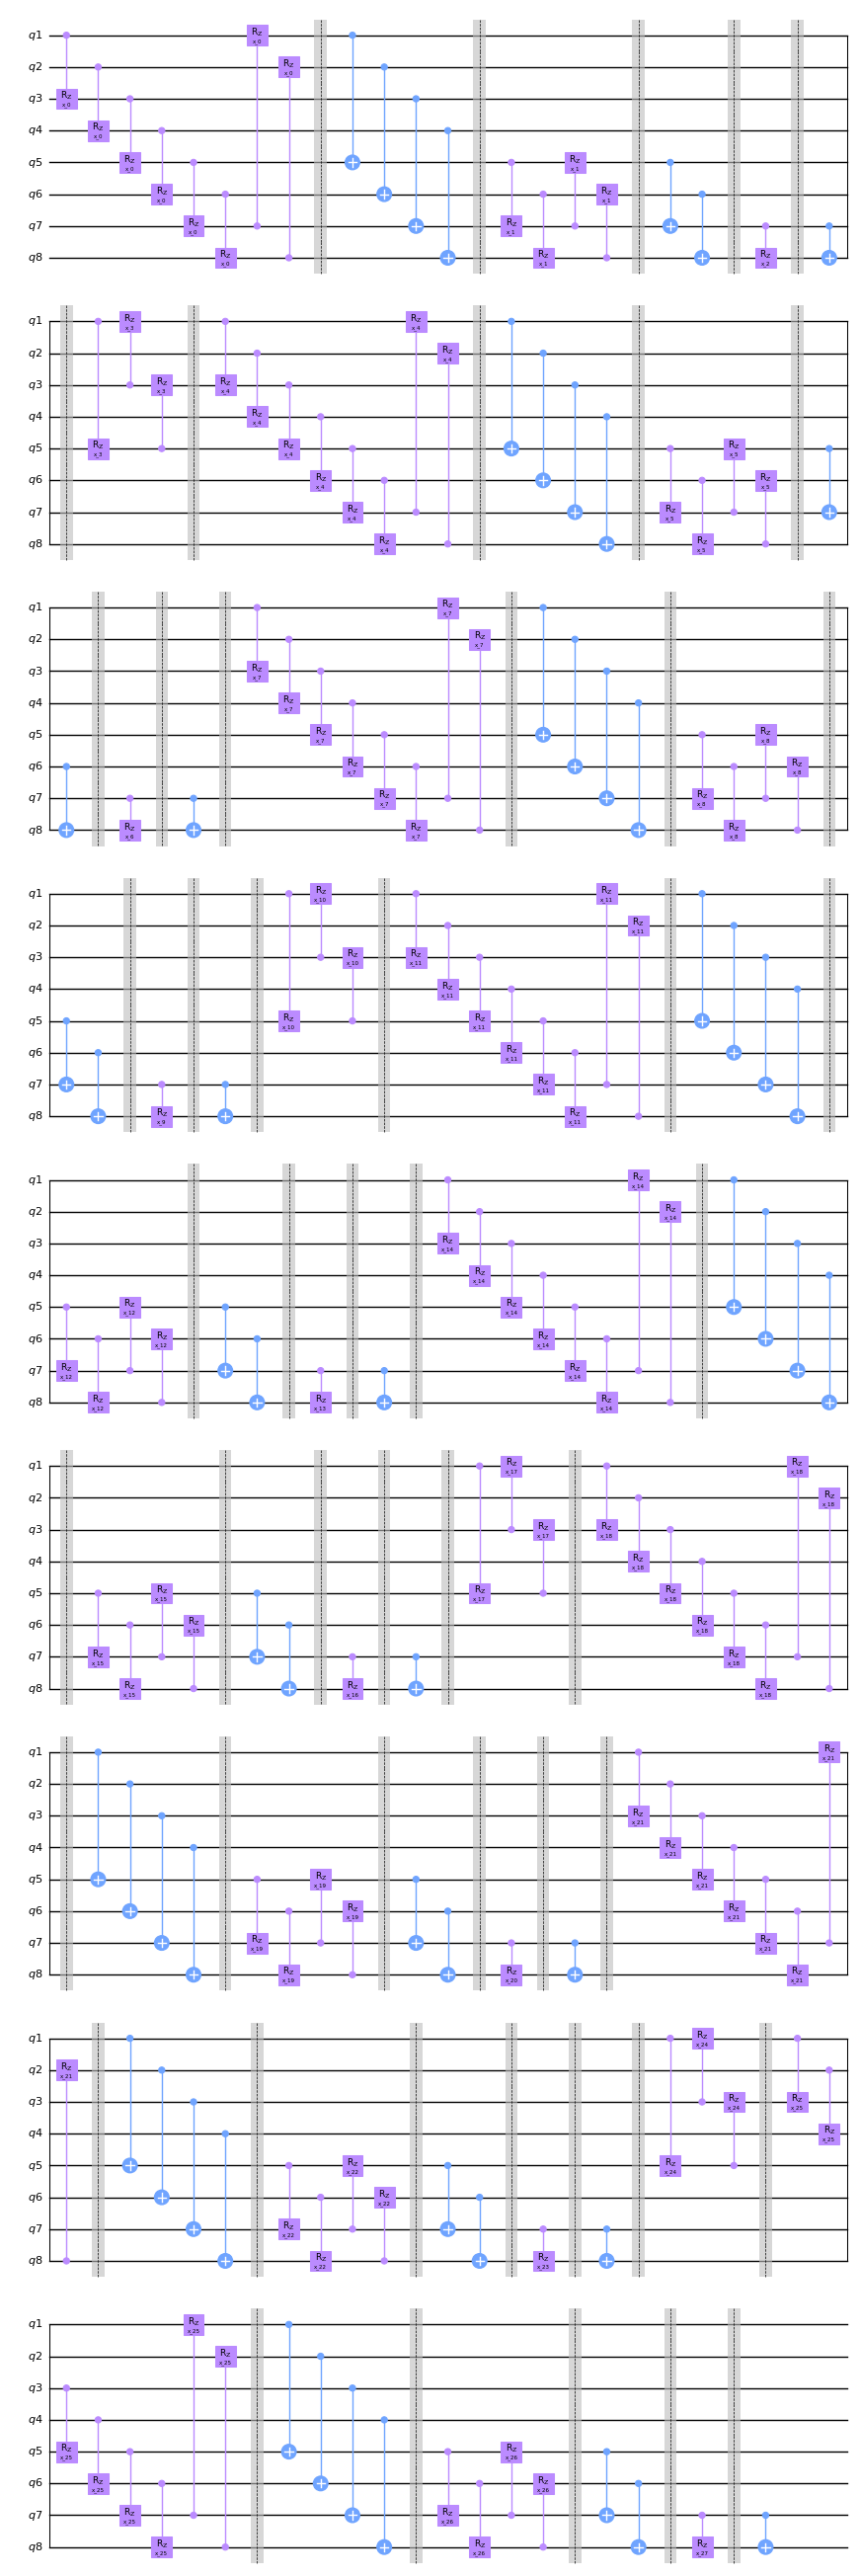

In [65]:
N = 8
# level 1
m1_1 = Qconv(2)
m1_2 = Qpool(filter="left")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_qiskit(
    (m3_1 + Qfree([1, 3, 5]) + Qconv(5) + m3_1) * 4
)
circuit.draw("mpl", scale=0.5)

## Multiscale Entanglement Renormalization Ansatz (MERA)

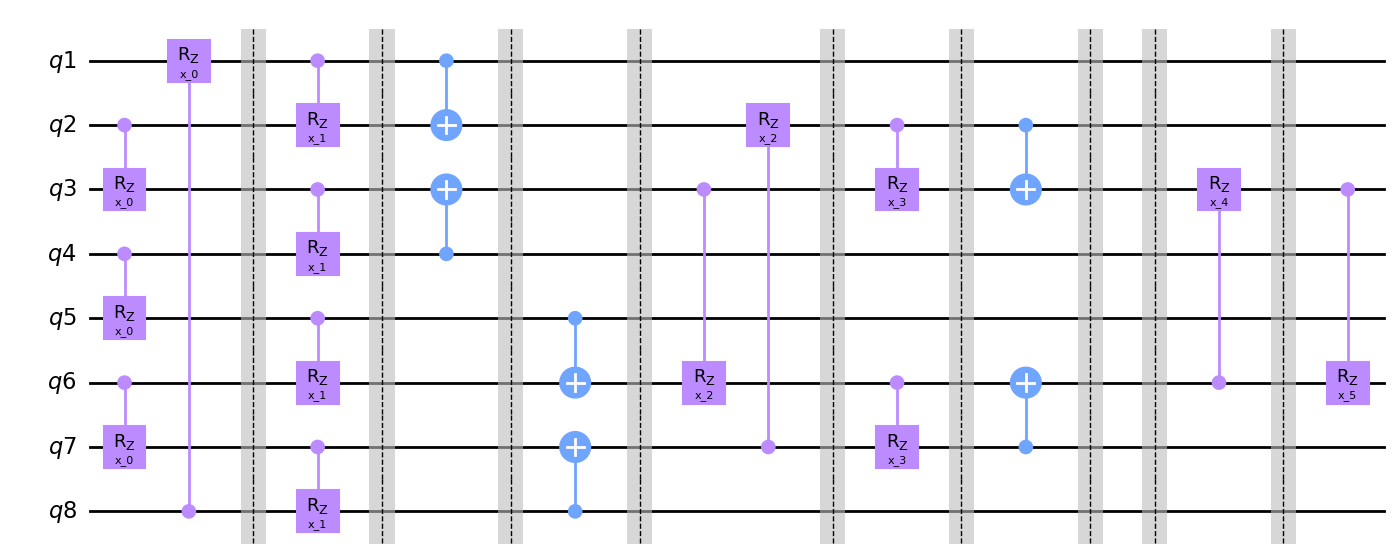

In [66]:
### MERA like
N = 8
# level 1
m1_1 = Qconv(1, 2)
m1_2 = Qconv(1, 2, 1)
m1_3 = Qpool(filter="1001")
m1_4 = Qpool(2, filter="001001")
m1_5 = Qpool(filter="outside")
# level 2
m2_1 = m1_2 + m1_1
m2_2 = m1_3 + m1_4
m2_3 = m1_5
# level 3
m3_1 = Qfree(N) + (m2_1 + m2_2) * 2 + m2_1

circuit, symbols = convert_graph_to_circuit_qiskit(m3_1)
circuit.draw("mpl")

## Random QCNNs

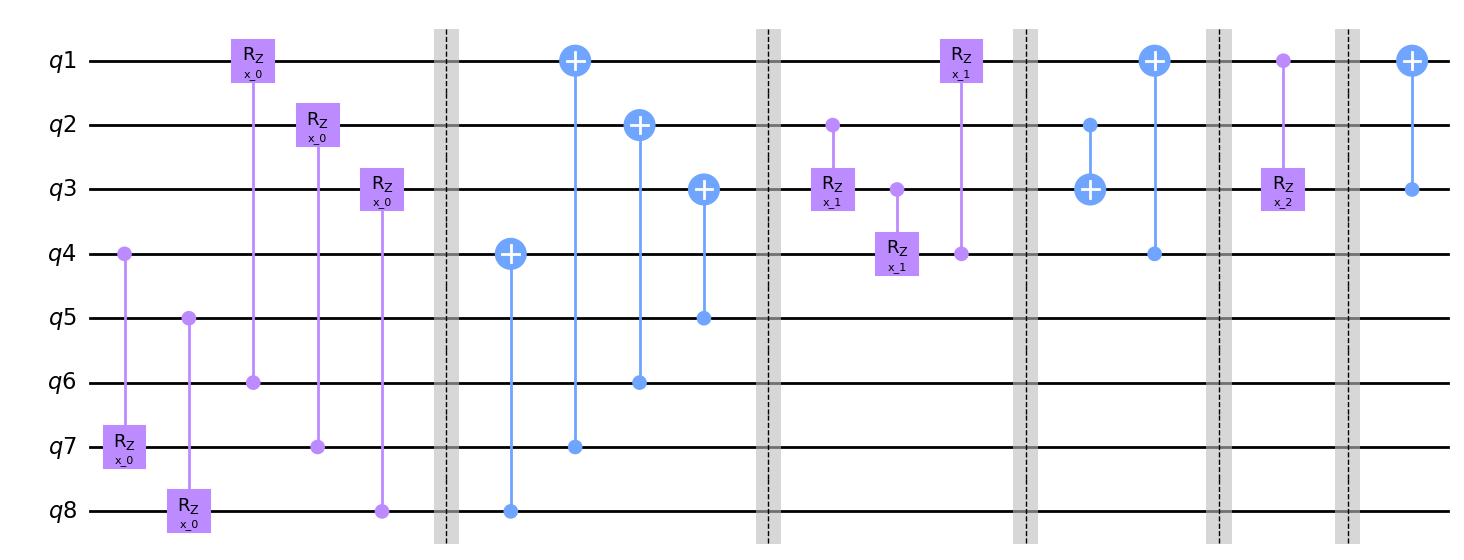

In [67]:
# More structure
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ]  # + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_qiskit(M)
circuit.draw("mpl")

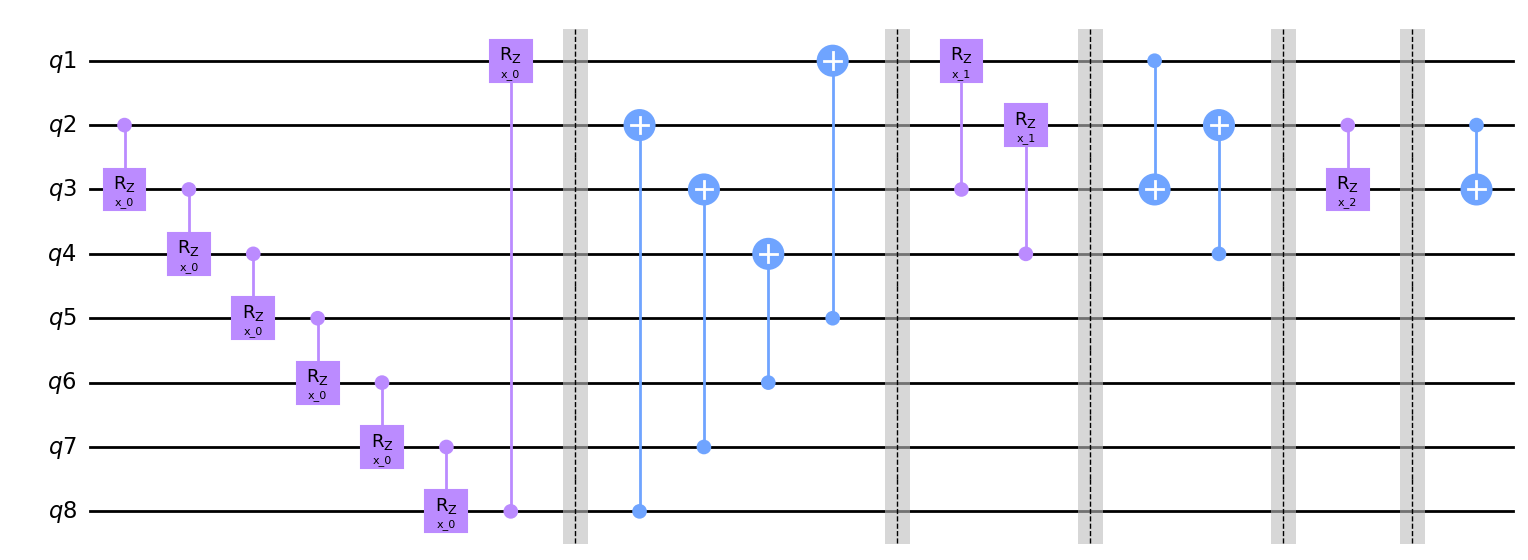

In [68]:
# loose
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ] + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_qiskit(M)
circuit.draw("mpl")

<a id='sec_customunitary'></a>
## Specifying custom unitaries

In [16]:
# Pooling circuit
def V(bits, symbols=None, circuit=None):
    if type(bits[0]) == int:
        q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    else:
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0, q1)
    # gate operations:
    circuit.crz(symbols[0], q0, q1)
    return circuit


# Convolution circuit
def U(bits, symbols=None, circuit=None):
    if type(bits[0]) == int:
        q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    else:
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0, q1)
    # gate operations:
    circuit.cnot(q0, q1)
    circuit.ry(symbols[0], q0)
    circuit.ry(symbols[1], q1)
    circuit.cnot(q0, q1)
    circuit.ry(symbols[2], q0)
    circuit.ry(symbols[3], q1)
    return circuit

**Convolution**

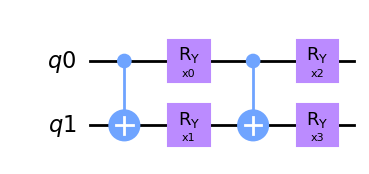

In [17]:
convolution_ansatz = U([0, 1], [Parameter(f"x{i}") for i in range(4)])
convolution_ansatz.draw("mpl")

**Pooling**

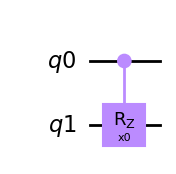

In [18]:
pooling_ansatz = V([0, 1], [Parameter("x0")])
pooling_ansatz.draw("mpl")

In [23]:
m = (
    Qfree([f"q{i}" for i in range(8)])
    + (
        Qconv(1, convolution_mapping=(U, 6))
        + Qpool(filter="left", pooling_mapping=(V, 1))
    )
    * 3
)
circuit, symbols = convert_graph_to_circuit_qiskit(m)

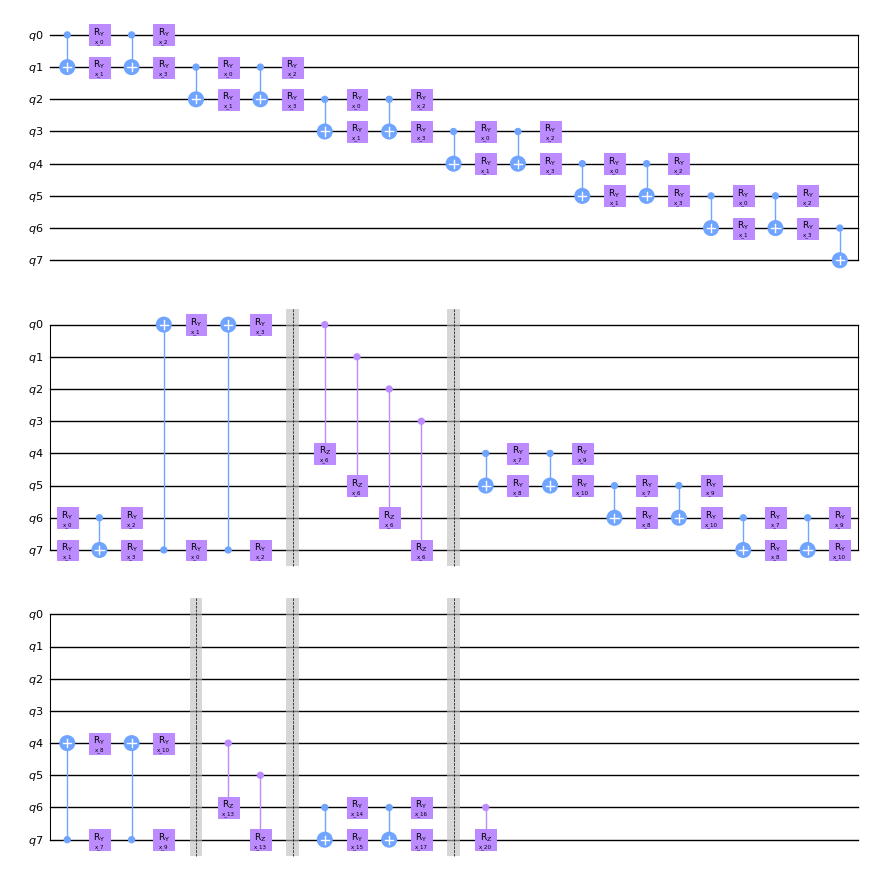

In [24]:
circuit.draw("mpl", scale=0.5)

### Cycle through unitary ansatzes

In [25]:
# Pooling circuit
def V_1(bits, symbols=None, circuit=None):  # 1
    if type(bits[0]) == int:
        q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    else:
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0, q1)
    circuit.crx(symbols[0], q0, q1)
    return circuit


def V_2(bits, symbols=None, circuit=None):  # 0
    if type(bits[0]) == int:
        q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    else:
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0, q1)
    circuit.cnot(q0, q1)
    return circuit


# Convolution circuit
def U_1(bits, symbols=None, circuit=None):  # 1
    if type(bits[0]) == int:
        q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    else:
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0, q1)
    circuit.crz(symbols[0], q0, q1)
    return circuit


def U_2(bits, symbols=None, circuit=None):  # 1
    if type(bits[0]) == int:
        q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    else:
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0, q1)
    circuit.cry(symbols[0], q0, q1)
    return circuit


function_mappings = {
    "convolution": [(U_1, 1), (U_2, 1)],
    "pooling": [(V_1, 1), (V_2, 0)],
}

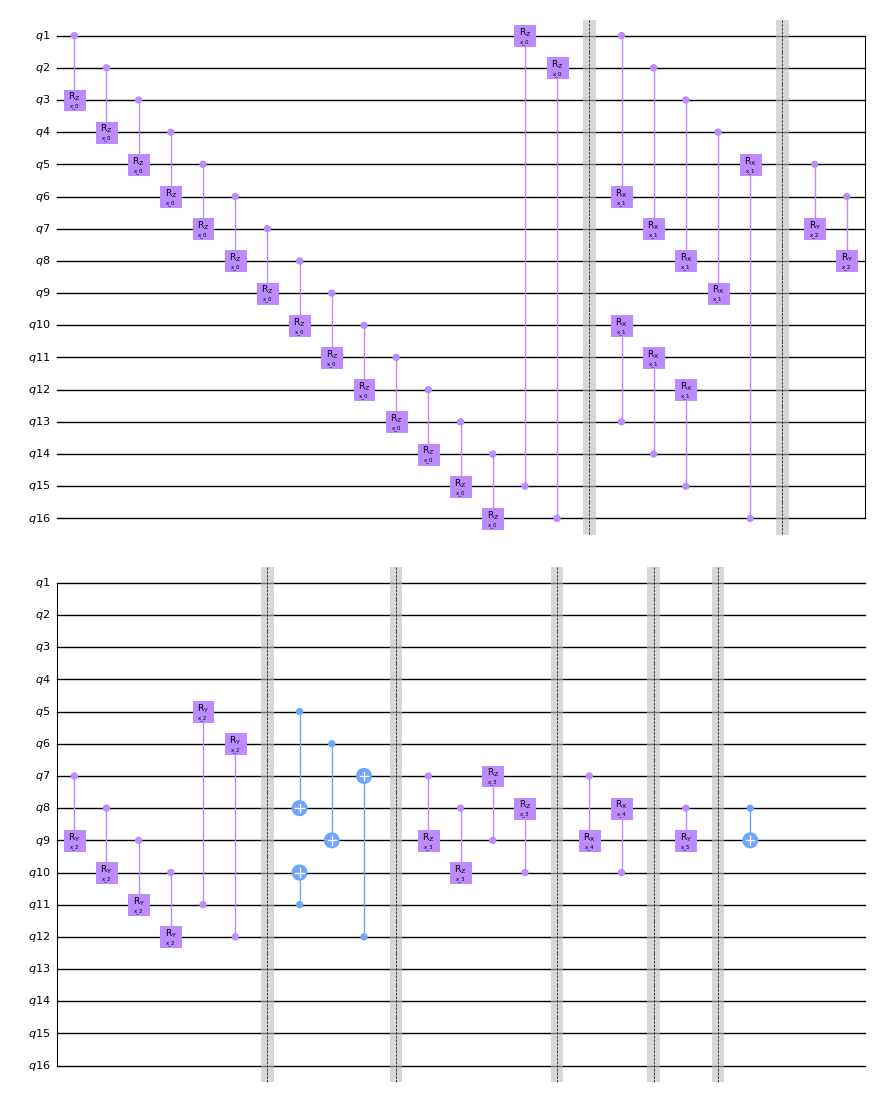

In [26]:
qcnn = Qcnn(16, function_mappings=function_mappings)

qcnn = qcnn + (Qconv(2) + Qpool(1, "outside")) * 4
circuit, symbols = convert_graph_to_circuit_qiskit(qcnn)
circuit.draw("mpl", scale=0.5)

### Plotting the directed graph representation

**Plot single motif:**

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

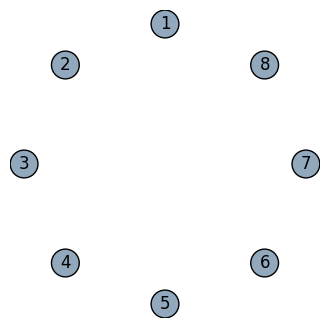

In [27]:
m = Qfree(8) + (Qconv(1) + Qpool(filter="right")) * 3

plot_motif(m.tail)

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

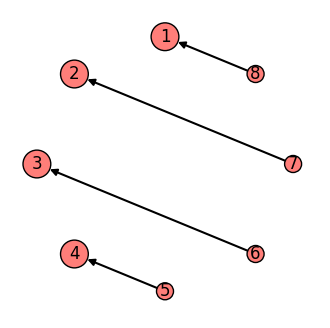

In [28]:
plot_motif(m.tail.next.next)

**Plot full qcnn**


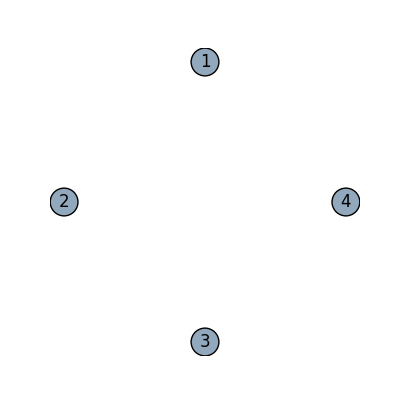
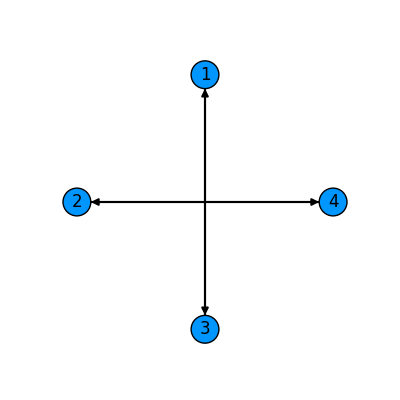
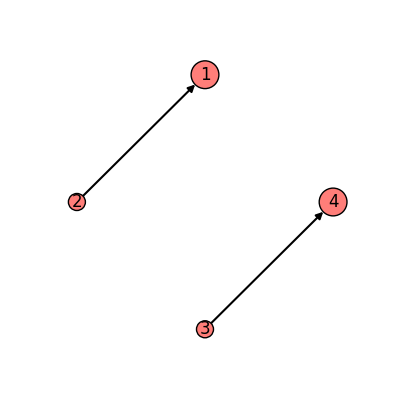
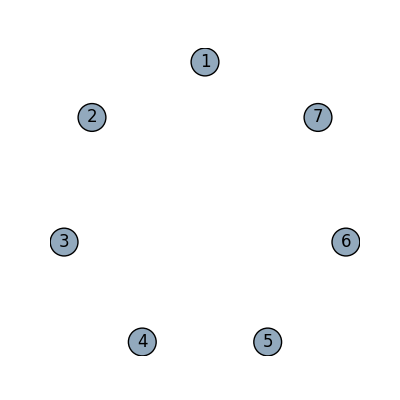
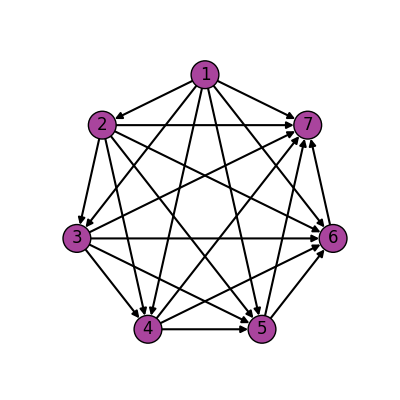
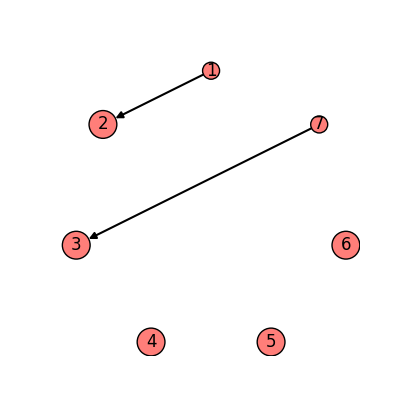

In [29]:
m = (
    Qfree(4)
    + Qconv(2)
    + Qpool(filter="inside")
    + Qfree(7)
    + Qdense()
    + Qpool(filter="1000001")
)
# If all_motifs=false then only operational motifs are plotted, i.e. not Qfree motifs
a = plot_motifs(m, all_motifs=True, figsize=(4, 4))